# Part 1: Fourier Neural Operator (FNO)

The following libraries will be necessary for your implementation. Ensure you have them installed before proceeding.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from typing import List, Union
from neuralop import Trainer
from neuralop.data.datasets.darcy import load_darcy_flow_small
from neuralop.utils import count_model_params
from neuralop import LpLoss, H1Loss
from spectral_convolution import SpectralConvolution
from mlp import MLP

# PyTorch random number generator
torch.manual_seed(1234)
np.random.seed(1234)

device = 'cpu'

### Building the FNO

We will implement the Fourier Neural Operator (FNO) class, an advanced neural network model used for solving Partial Differential Equations (PDEs) through deep learning. The FNO utilizes Fourier transformations to learn global representations and can be particularly effective for high-dimensional data.

Let's start with the Fourier block which you will implement using the modules `SpectralConvolution` and `MLP`. You are given the constructor and you will have to work on the forward pass.

In [2]:
class FourierBlock(nn.Module):
    """
    Fourier block used in the Fourier Neural Operator (FNO).
    Combines spectral convolution, MLP, and convolution layers.
    """
    def __init__(self, modes: Union[List[int], int], in_channels: int, out_channels: int, 
                 hidden_size: int, activation: nn.Module = nn.GELU()) -> None:
        super().__init__()
        
        # Initialize the spectral convolution (Fourier layer)
        self.fourier = SpectralConvolution(in_channels, out_channels, modes)

        # MLP layer (which will do a linear transformation of the input)
        self.mlp = MLP(len(modes), in_channels, out_channels, hidden_size, activation)

        # Initialize the 2D convolution layer with kernel size of 3 and padding of 1
        self.conv = nn.Conv2d(in_channels, out_channels, 3, padding=1)

        # Activation function for the block
        self.activation = activation

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the FourierBlock.
        
        Parameters:
        ----------
        x: torch.Tensor
            Input tensor of shape [batch, channels, *sizes]
        
        Returns:
        -------
        x: torch.Tensor
            Output tensor of shape [batch, channels, *sizes]
        """

        # TODO - Apply spectral convolution to input tensor
        x_ft = self.fourier(x)

        # TODO - Apply 2D convolution to input tensor
        x_conv = self.mlp(x)

        # Add the Fourier and convolution outputs
        x = x_ft + x_conv

        # TODO - Apply MLP to the result
        x_mlp = self.mlp(x)

        # TODO - Apply activation function to the final result

        x = self.activation(x_mlp)
        return x


Below is the skeleton of the `FNO` class. Certain parts are intentionally left blank for you to complete - **marked TODO for code you need to complete**. Follow the comments to understand what each part should accomplish.

In [3]:
class FNO(nn.Module):
    """
    Fourier Neural Operator (FNO) for solving PDEs.
    """
    def __init__(self, modes: List[int], num_fourier_layers: int, in_channels: int, 
                 lifting_channels: int, projection_channels: int, out_channels: int, 
                 hidden_channels: int, activation: nn.Module):
        super().__init__()
        self.dim = len(modes)
        self.activation = activation

        # Lifting layer 
        self.lifting = MLP(2, in_channels, lifting_channels, hidden_channels)
        
        # TODO - Initialize a list of FourierBlock modules with modes, hidden_channels, hidden_size and activation as parameters.
        #        You are free to choose which hidden_size is best for the model
        self.fourier_blocks = nn.ModuleList([
            FourierBlock(modes, lifting_channels, lifting_channels, hidden_channels, activation)
            for _ in range(num_fourier_layers)
        ])
            
        # TODO - Use projection layers
        self.q1 = nn.Conv2d(lifting_channels, projection_channels, 1)  # Projection layer 1
        self.final = nn.Conv2d(projection_channels, out_channels, 1)  # Final layer to map to output channels

    def forward(self, x: torch.Tensor, **kwargs) -> torch.Tensor:
        #print(x.shape)
        # TODO - Implement lifting layer
        x = self.lifting(x)
        #print(x.shape)
        # TODO - Pass the input through each FourierBlock sequentially
        for fourier_block in self.fourier_blocks:
            x = fourier_block(x)
        #print('f',x.shape)
        
        # Permute the dimensions back to [batch, sizes, channels].
        #x = x.permute(0, *range(2, self.dim + 2), 1)
        #x = x.permute(0, 2, 3, 1)
        #print('p',x.shape)
        # TODO - Apply projection and final layer
        x = self.q1(x)   
        #print('q1',x.shape)
        x = self.activation(x)
        #print('a',x.shape)
        x = self.final(x)
        #print('final',x.shape)
        # Permute to [batch, channels, sizes] format for output and return.
        return x
        #return x.permute(0, -1, *range(1, self.dim + 1))
        #return x.permute(0, 2, 3, 1)

### Training the Fourier Neural Operator on Darcy Flow

In this example, we demonstrate how to use the small Darcy-Flow example we ship with the package "neuralop" to train a Tensorized Fourier-Neural Operator.

*There is no code to fill in for this part, just run the code block by block in order.*

**Loading the Navier-Stokes dataset in 128x128 resolution:**

In [4]:
# Load Darcy flow dataset
train_loader, test_loaders, data_processor = load_darcy_flow_small(
    n_train=1000, batch_size=32, test_resolutions=[16, 32], n_tests=[100, 50],
    test_batch_sizes=[32, 32], positional_encoding=True
)
data_processor = data_processor.to(device)

Loading test db for resolution 16 with 100 samples 
Loading test db for resolution 32 with 50 samples 


Let's create an instance of our FNO model

In [5]:
# Initialize model
# TODO - Tune hyperparameters of FNO; 
# hint: use small values for channels and no more than 6 layers

model = FNO(modes=[16, 16], num_fourier_layers=2, in_channels=3,
            lifting_channels=8, hidden_channels=32, projection_channels=4,
            out_channels=1, activation=nn.GELU())
model = model.to(device)

# Count model parameters
n_params = count_model_params(model)
print(f'\nModel parameters: {n_params}')


Model parameters: 133777


Here's a quick visualization of the input and ground truth data:

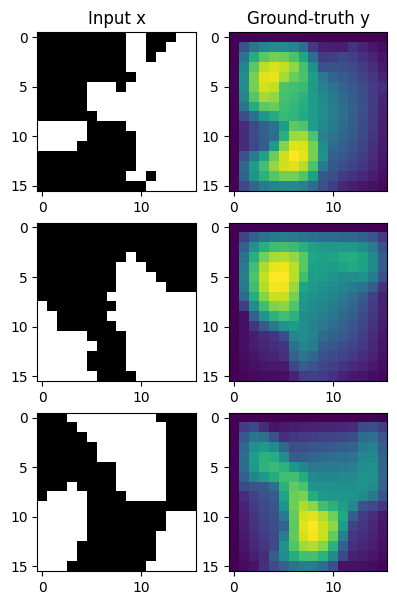

In [6]:
#You can change the resolution from 16 to 32 to see the resolution difference if you'd like.
#Note: Because DeepONet trains and tests on same resolution, and our Darcy Flow dataset only contains training
# data of resolution 16, testing with 16 here is recommended for a better comparison (in DeepONet section of this HW).
test_samples = test_loaders[16].dataset

fig = plt.figure(figsize=(7, 7))
for index in range(3):
    data = test_samples[index]
    data = data_processor.preprocess(data, batched=False)
    # Input x
    x = data['x']
    # Ground-truth
    y = data['y']

    ax = fig.add_subplot(3, 3, index*3 + 1)
    ax.imshow(x[0], cmap='gray')
    if index == 0:
        ax.set_title('Input x')   

    ax = fig.add_subplot(3, 3, index*3 + 2)
    ax.imshow(y.squeeze())
    if index == 0:
        ax.set_title('Ground-truth y')


Create the optimizer and losses.

In [7]:
# Losses and optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
l2loss = LpLoss(d=2, p=2)
h1loss = H1Loss(d=2)
train_loss = h1loss
eval_losses = {'h1': h1loss, 'l2': l2loss}

Visualize created instances for model and others.

In [8]:
print('\n### MODEL ###\n', model)
print('\n### OPTIMIZER ###\n', optimizer)
print('\n### SCHEDULER ###\n', scheduler)
print('\n### LOSSES ###')
print(f'\n * Train: {train_loss}')
print(f'\n * Test: {eval_losses}')


### MODEL ###
 FNO(
  (activation): GELU(approximate='none')
  (lifting): MLP(
    (activation): GELU(approximate='none')
    (mlp1): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
    (mlp2): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
  )
  (fourier_blocks): ModuleList(
    (0-1): 2 x FourierBlock(
      (fourier): SpectralConvolution(
        (weights_real): ParameterList(
            (0): Parameter containing: [torch.float32 of size 8x8x16x16]
            (1): Parameter containing: [torch.float32 of size 8x8x16x16]
        )
        (weights_imag): ParameterList(
            (0): Parameter containing: [torch.float32 of size 8x8x16x16]
            (1): Parameter containing: [torch.float32 of size 8x8x16x16]
        )
      )
      (mlp): MLP(
        (activation): GELU(approximate='none')
        (mlp1): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
        (mlp2): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
      )
      (conv): Conv2d(8, 8, kernel_size=(3, 3), stri

Train the model using the trainer. For 20 epochs, it should take a few minutes only.

Aim for your `16_l2` metric (L2 loss in 16x16 resolution images) to be less than 0.5.

In [9]:
# Train model
trainer = Trainer(model=model, n_epochs=20, device=device, data_processor=data_processor,
                 use_distributed=False, verbose=True)
trainer.train(train_loader=train_loader, test_loaders=test_loaders,
              optimizer=optimizer, scheduler=scheduler, 
              regularizer=False, training_loss=train_loss, eval_losses=eval_losses)

Training on 1000 samples
Testing on [50, 50] samples         on resolutions [16, 32].
Raw outputs of shape torch.Size([32, 1, 16, 16])
[0] time=2.28, avg_loss=1.0095, train_err=31.5464
Eval: 16_h1=0.5112, 16_l2=0.4531, 32_h1=0.5225, 32_l2=0.4545
[1] time=2.19, avg_loss=0.9984, train_err=31.1991
Eval: 16_h1=0.3640, 16_l2=0.2787, 32_h1=0.4258, 32_l2=0.3365
[2] time=2.18, avg_loss=0.8722, train_err=27.2567
Eval: 16_h1=0.4347, 16_l2=0.2831, 32_h1=0.4693, 32_l2=0.3228
[3] time=2.24, avg_loss=0.6693, train_err=20.9145
Eval: 16_h1=0.5155, 16_l2=0.3360, 32_h1=0.4657, 32_l2=0.3300
[4] time=2.20, avg_loss=0.5510, train_err=17.2186
Eval: 16_h1=0.5308, 16_l2=0.3634, 32_h1=0.4673, 32_l2=0.3399
[5] time=2.33, avg_loss=0.4932, train_err=15.4111
Eval: 16_h1=0.6320, 16_l2=0.4725, 32_h1=0.4985, 32_l2=0.3649
[6] time=2.38, avg_loss=0.4645, train_err=14.5162
Eval: 16_h1=0.6289, 16_l2=0.4687, 32_h1=0.4901, 32_l2=0.3452
[7] time=2.31, avg_loss=0.4562, train_err=14.2569
Eval: 16_h1=0.6298, 16_l2=0.4686, 32_h

{'train_err': 10.750337436795235,
 'avg_loss': 0.3440107979774475,
 'avg_lasso_loss': None,
 'epoch_train_time': 2.316910916939378,
 '16_h1': tensor(0.6145),
 '16_l2': tensor(0.4527),
 '32_h1': tensor(0.6729),
 '32_l2': tensor(0.3262)}

### Plot the prediction, and compare with the ground-truth

*Note:*
- *We trained on a very small resolution for a very small number of epochs. In practice, we would train at larger resolution, on many more samples.*
- *However, for practicity, we created a minimal example that*
  - *fits in just a few Mb of memory*
  - *can be trained quickly on CPU*

*In practice we would train a Neural Operator on one or multiple GPUs*

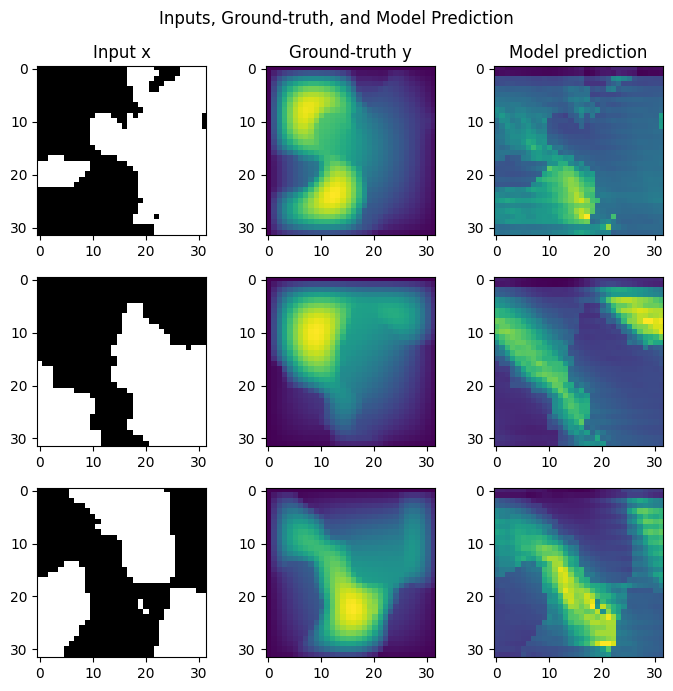

In [10]:
# Visualization of predictions
test_samples = test_loaders[32].dataset
fig = plt.figure(figsize=(7, 7))
for index in range(3):
    data = test_samples[index]
    data = data_processor.preprocess(data, batched=False)
    x = data['x']
    y = data['y']
    out = model(x.unsqueeze(0))

    ax = fig.add_subplot(3, 3, index*3 + 1)
    ax.imshow(x[0], cmap='gray')
    if index == 0:
        ax.set_title('Input x')

    ax = fig.add_subplot(3, 3, index*3 + 2)
    ax.imshow(y.squeeze())
    if index == 0:
        ax.set_title('Ground-truth y')

    ax = fig.add_subplot(3, 3, index*3 + 3)
    ax.imshow(out.squeeze().detach().numpy())
    if index == 0:
        ax.set_title('Model prediction')

fig.suptitle('Inputs, Ground-truth, and Model Prediction')
plt.tight_layout()
plt.savefig('neural_ops_output.png', dpi=500, bbox_inches='tight')
plt.show()

# Part 2: DeepONets

In this section, you will implement the DeepONet class, another advanced neural network model used for solving Partial Differential Equations (PDEs) through deep learning. The trunk and branch method in DeepONet allows for the separation of input functions and locations, enabling efficient and flexible learning of nonlinear operators by independently processing the function space and input space.

Below is the skeleton of the `DeepONet` class. Certain parts are intentionally left blank for you to complete - **marked TODO for code you need to complete**. Follow the comments to understand what each part should accomplish.

In [11]:
import os
os.environ["DDE_BACKEND"] = "pytorch"
import deepxde as dde
from deepxde.nn import FNN
from deepxde.nn import NN
from deepxde.nn import activations
from deepxde.nn.pytorch.deeponet import (
    SingleOutputStrategy,
    IndependentStrategy,
    SplitBothStrategy,
    SplitBranchStrategy,
    SplitTrunkStrategy,
)

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


In [12]:
class DeepONet(NN):
    """Deep operator network.

    `Lu et al. Learning nonlinear operators via DeepONet based on the universal
    approximation theorem of operators. Nat Mach Intell, 2021.
    <https://doi.org/10.1038/s42256-021-00302-5>`_

    """

    def __init__(
        self,
        layer_sizes_branch,
        layer_sizes_trunk,
        activation,
        kernel_initializer,
        num_outputs=1,
        multi_output_strategy=None,
    ):
        super().__init__()
        # Define activation functions for the branch and trunk networks
        if isinstance(activation, dict):
            self.activation_branch = activation["branch"]
            self.activation_trunk = activations.get(activation["trunk"])
        else:
            self.activation_branch = self.activation_trunk = activations.get(activation)
        self.kernel_initializer = kernel_initializer

        self.num_outputs = num_outputs
        if self.num_outputs == 1:
            if multi_output_strategy is not None:
                raise ValueError(
                    "num_outputs is set to 1, but multi_output_strategy is not None."
                )
        elif multi_output_strategy is None:
            multi_output_strategy = "independent"
            print(
                f"Warning: There are {num_outputs} outputs, but no multi_output_strategy selected. "
                'Use "independent" as the multi_output_strategy.'
            )
        self.multi_output_strategy = {
            None: SingleOutputStrategy,
            "independent": IndependentStrategy,
            "split_both": SplitBothStrategy,
            "split_branch": SplitBranchStrategy,
            "split_trunk": SplitTrunkStrategy,
        }[multi_output_strategy](self)


        # Build the branch and trunk networks
        # Use the selected multi-output strategy to build the branch and trunk networks
        # The multi_output_strategy.build() method is expected to return two network components,
        # which will be assigned to self.branch and self.trunk
        self.branch, self.trunk = self.multi_output_strategy.build(
            layer_sizes_branch, layer_sizes_trunk
        )
        if isinstance(self.branch, list):
            self.branch = torch.nn.ModuleList(self.branch)
        if isinstance(self.trunk, list):
            self.trunk = torch.nn.ModuleList(self.trunk)
        
        # TODO: Initialize learnable parameters for output bias
        # self.b should be a list of learnable parameters (torch.nn.Parameter) for each output
        # Initialize these parameters with zeros using torch.nn.Parameter(torch.tensor(0.0))
        self.b = torch.nn.ParameterList(
            [torch.nn.Parameter(torch.tensor(0.0)) for _ in range(num_outputs)]
        )

    def build_branch_net(self, layer_sizes_branch):
        # Implement the branch network construction
        # Check if layer_sizes_branch[1] is a callable function (user-defined network)
        # If it is, return it directly. Otherwise, create a fully connected network (FNN)
        # using the provided layer_sizes_branch and activation function.
        # User-defined network: If the second element of layer_sizes_branch is a callable, return it
        if callable(layer_sizes_branch[1]):
            return layer_sizes_branch[1]
            
        # TODO: Return fully connected network: Create an FNN with specified layer sizes and activation function
        return FNN(layer_sizes_branch, self.activation_branch)

    def build_trunk_net(self, layer_sizes_trunk):
        # TODO: Implement the trunk network construction
        # Similar to the branch network, create a fully connected network (FNN)
        # using the provided layer_sizes_trunk and activation function.
        return FNN(layer_sizes_trunk, self.activation_branch)

    def merge_branch_trunk(self, x_func, x_loc, index):
        # Merging of branch and trunk outputs
        # Use torch.einsum with the expression "bi,bi->b" to perform element-wise
        # multiplication of x_func and x_loc, followed by a summation over the last dimension.
        # The result should be reshaped using torch.unsqueeze to add a new dimension.
        # Finally, add the output bias self.b[index] to the result.
        y = torch.einsum("bi,bi->b", x_func, x_loc)
        y = torch.unsqueeze(y, dim=1)
        y += self.b[index]
        return y

    def forward(self, inputs):
        x_func = inputs[0]
        x_loc = inputs[1]
        
        # TODO: Use the multi-output strategy to process the inputs
        # Hint: Call self.multi_output_strategy.call() with x_func and x_loc.
        x = self.multi_output_strategy.call(x_func, x_loc)
        x = self.concatenate_outputs(x)
        return x

    @staticmethod
    def concatenate_outputs(ys):
        return torch.concat(ys, dim=1)


### Training with DeepONet in Darcy flow

Having trained and tested the FNO model, you will now use the same small Darcy-Flow dataset with the package "deepxde" to train a Tensorized DeepONet model.

*There is no code to fill in for this part, just run the code block by block in order.*

**Loading and extracting the Darcy Flow small dataset:**

In [13]:
train_data = torch.load("data/darcy_train_16.pt")
test_data = torch.load("data/darcy_test_16.pt")

x_train = train_data['x'].float()
y_train = train_data['y'].float()

x_test = test_data['x'].float()
y_test = test_data['y'].float()

data = dde.data.Triple(X_train=x_train, y_train=y_train, X_test=x_test, y_test=y_test)

**Configure the DeepONet model:**

In [14]:
# Choose a network
m = 16
dim_x = 16
net = dde.nn.DeepONet(
    [m, 16, 16, 16],
    [dim_x, 16, 16, 16],
    "relu",
    "Glorot normal",
    num_outputs=16,
    multi_output_strategy="independent",
)

# Define a Model
model = dde.Model(data, net)

Compile and train the model using the Adam Optimizer with a learning rate of 0.001 (Execution time ≈ 3min)

In [15]:
model.compile("adam", lr=0.001)
losshistory, train_state = model.train(iterations=10000)

Compiling model...
'compile' took 0.002633 s

Training model...

Step      Train loss    Test loss     Test metric
0         [4.30e-01]    [4.96e-01]    []  
1000      [6.60e-02]    [2.58e-01]    []  
2000      [6.60e-02]    [2.58e-01]    []  
3000      [6.60e-02]    [2.57e-01]    []  
4000      [6.60e-02]    [2.50e-01]    []  
5000      [6.60e-02]    [2.39e-01]    []  
6000      [6.60e-02]    [2.25e-01]    []  
7000      [6.60e-02]    [2.15e-01]    []  
8000      [6.60e-02]    [1.89e-01]    []  
9000      [6.60e-02]    [1.82e-01]    []  
10000     [6.60e-02]    [1.74e-01]    []  

Best model at step 8000:
  train loss: 6.60e-02
  test loss: 1.89e-01
  test metric: []

'train' took 102.741714 s



Plot the prediction and compare with the ground-truth data

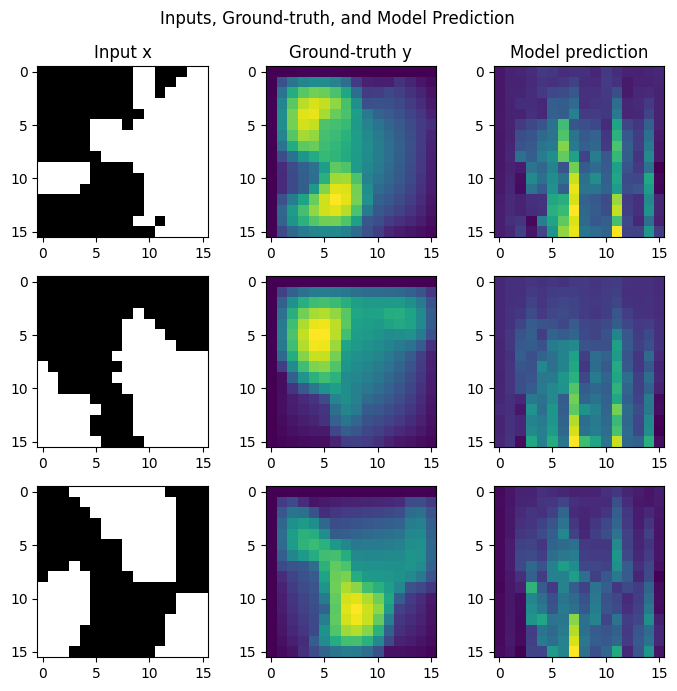

In [16]:
# Visualization of predictions
test_samples = test_loaders[16].dataset
fig = plt.figure(figsize=(7, 7))
for index in range(3):
    data = test_samples[index]
    data = data_processor.preprocess(data, batched=False)
    x = data['x']
    y = data['y']
    out = model.predict(x.detach().numpy())

    ax = fig.add_subplot(3, 3, index*3 + 1)
    ax.imshow(x[0], cmap='gray')
    if index == 0:
        ax.set_title('Input x')

    ax = fig.add_subplot(3, 3, index*3 + 2)
    ax.imshow(y.squeeze())
    if index == 0:
        ax.set_title('Ground-truth y')

    ax = fig.add_subplot(3, 3, index*3 + 3)
    ax.imshow(out.squeeze())
    if index == 0:
        ax.set_title('Model prediction')

fig.suptitle('Inputs, Ground-truth, and Model Prediction')
plt.tight_layout()
plt.savefig('neural_ops_output.png', dpi=500, bbox_inches='tight')
plt.show()

## Q: You might observe that the Fourier Neural Operator (FNO) significantly outperforms the DeepONet model in terms of prediction accuracy on the Darcy flow dataset. Provide a brief explanation (in a couple of sentences) as to why this might be the case. Think about both the architecture of each model and the experimental setup.

## A: FNO is more effective at capturing global dependencies because it uses Fourier transforms to process data in the frequency domain, which allows it to better handle complex spatial patterns. On the other hand, DeepONet, with its branch and trunk networks, has difficulty representing these global relationships. This is reflected in its predictions, where the patterns appear split into distinct vertical segments, indicating weaker performance on the Darcy flow dataset.